## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

Ans: 由以下組合看出 batch-normalization after activation, 並搭配 regularizers 與 dropout 預測趨勢較接近實際測試

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# Global value #
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 1024
MOMENTUM = 0.95

# 參數沿用前面最佳結果
l1_l2_ratio = 1e-12
output_units = 10
num_neurons = [512, 256, 128]
drp_ratio = 0.25

In [6]:
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, ch_B, ch_R, ch_D):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        
        if i == 0:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(input_layer)
            
            if ch_B == 1:
                x = BatchNormalization()(x)
            if ch_R == 1:
                x = keras.layers.Dense(units=n_units, kernel_regularizer=l1_l2(l1_l2_ratio))(x)
            
            x = keras.layers.Dense(units=n_units, activation="relu")(x)
            
            if ch_B == 2:
                x = BatchNormalization()(x)
            if ch_R == 2:
                x = keras.layers.Dense(units=n_units, kernel_regularizer=l1_l2(l1_l2_ratio))(x)
            
            if ch_D == 1:
                x = Dropout(drp_ratio)(x)
                
        else:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(x)
            
            if ch_B == 1:
                x = BatchNormalization()(x)
            if ch_R == 1:
                x = keras.layers.Dense(units=n_units, kernel_regularizer=l1_l2(l1_l2_ratio))(x)
            
            x = keras.layers.Dense(units=n_units, activation="relu")(x)
            
            if ch_B == 2:
                x = BatchNormalization()(x)
            if ch_R == 2:
                x = keras.layers.Dense(units=n_units, kernel_regularizer=l1_l2(l1_l2_ratio))(x)
            
            if ch_D == 1:
                x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
def Training_Model(results, ch_B, ch_R, ch_D):
    
        model = build_mlp(x_train.shape[1:], ch_B, ch_R, ch_D)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        
        model.fit(x_train, y_train,
                  epochs = EPOCHS, 
                  batch_size = BATCH_SIZE,
                  validation_data = (x_test, y_test), 
                  shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
        
        exp_name_tag = "Result for %s " % str(ch_B)  
        exp_name_tag = exp_name_tag + "%s " % str(ch_R)
        exp_name_tag = exp_name_tag + "%s " % str(ch_D)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def Draw_Result(results, ch_B, ch_R, ch_D):
    color_bar = ["r", "g", "b", "y", "m", "k"]
    
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    
    sNB = ""
    if ch_B == 0:
        sNB = "No BN layer - "
    elif ch_B == 1:
        sNB = "BN before Activation - "
    elif ch_B == 2:
        sNB = "BN after Activation - "
    
    sRe = ""
    if ch_R == 0:
        sRe = "No regular - "
    elif ch_R == 1:
        sRe = "regular Activation - "
    elif ch_R == 2:
        sRe = "regular Activation - "
    
    sDr = ""
    if ch_D == 0:
        sDr = "No Drop - "
    elif ch_D == 1:
        sDr = " Drop - "
    
    plt.title(sNB + sRe + sDr + "Loss")
    plt.ylim([0, 20])
    plt.legend()
    plt.show()
        
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title(sNB + sRe + sDr + "Accuracy")
    plt.legend()
    plt.show()

In [12]:
result_111 = {}
Training_Model(result_111, 1, 1, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
__________

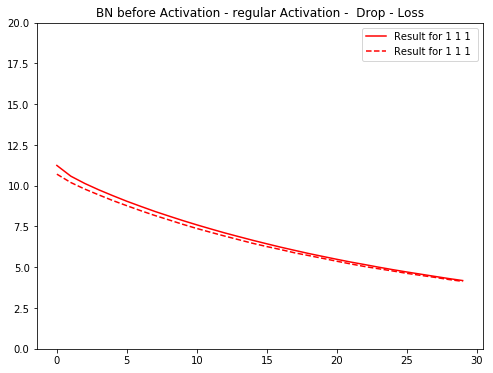

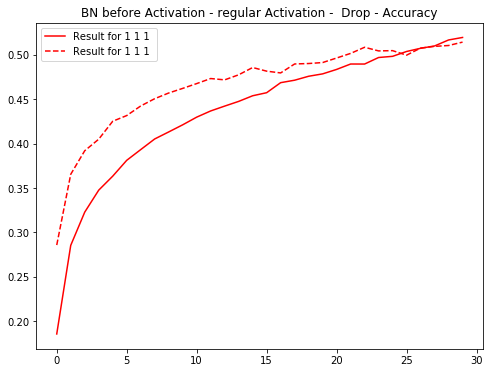

In [19]:
Draw_Result(result_111, 1, 1, 1)

In [20]:
result_110 = {}
Training_Model(result_110, 1, 1, 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
__________

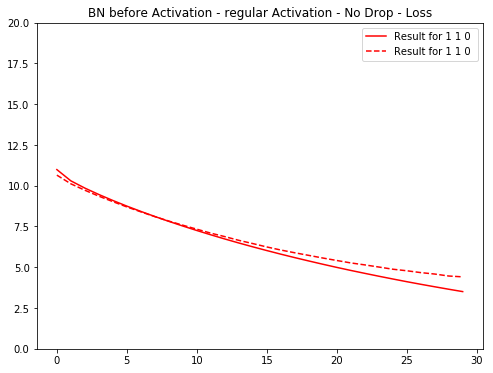

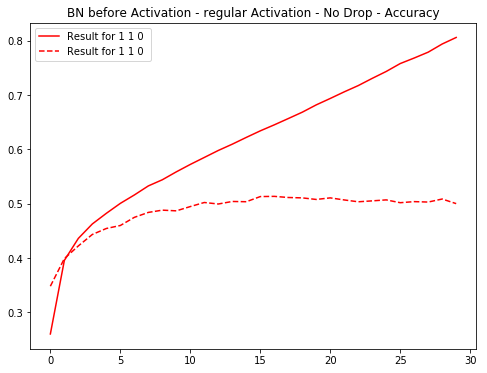

In [21]:
Draw_Result(result_110, 1, 1, 0)

In [22]:
result_121 = {}
Training_Model(result_121, 1, 2, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
__________

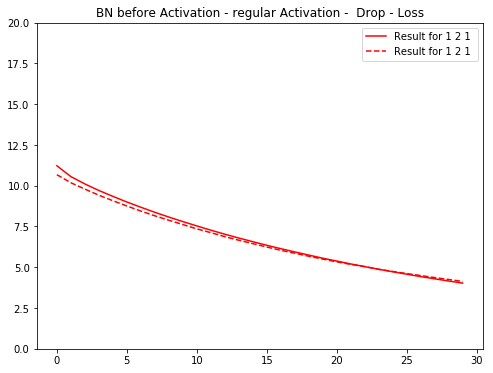

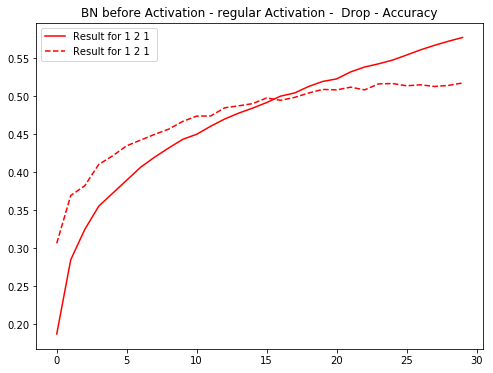

In [23]:
Draw_Result(result_121, 1, 2, 1)

In [24]:
result_211 = {}
Training_Model(result_211, 2, 1, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
__________

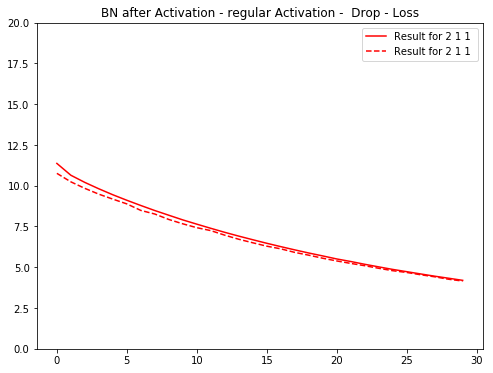

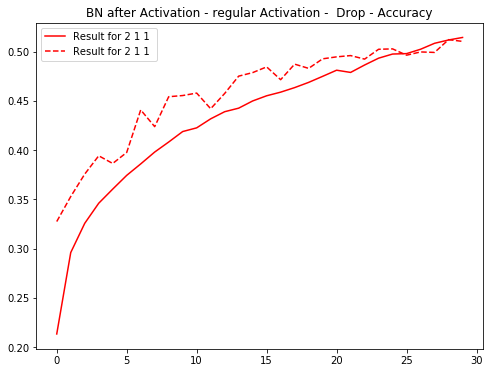

In [25]:
Draw_Result(result_211, 2, 1, 1)

In [26]:
result_221 = {}
Training_Model(result_221, 2, 2, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
dense_32 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
__________

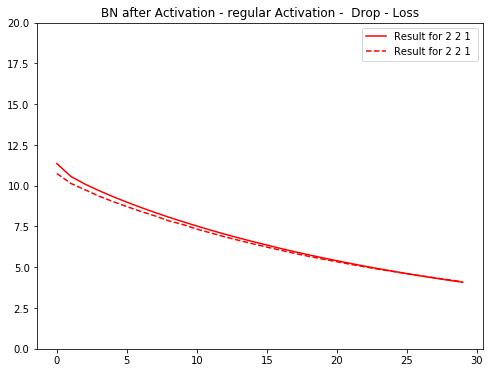

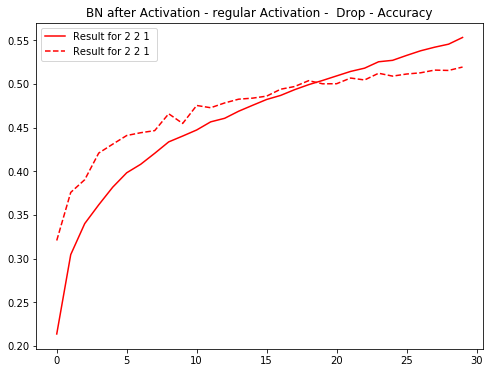

In [27]:
Draw_Result(result_221, 2, 2, 1)